## LeNet image classifier
* 128*128px 크기의 자전거, 자동차 이미지를 입력받아 학습한 뒤 이 모델을 기반으로 분류하는 이미지 분류기
* 학습용 이미지는 ./image/trainset 폴더에 종류별로 폴더 구분되어 있다.
* 테스트용 이미지는 ./image/testset 폴더에 종류별로 폴더 구분되어 있다.
* 요구사항: Python 3.7 or greater (include Pytorch, matplotlib, numpy)
---

In [1]:
print('Image classifier by -----------------')
print('''
  |_  ||_   _| | |  | | / _ \ | \ | |
    | |  | |   | |  | |/ /_\ \|  \| |
    | |  | |   | |/\| ||  _  || . ` |
/\__/ / _| |_  \  /\  /| | | || |\  |
\____/  \___/   \/  \/ \_| |_/\_| \_/
''')
print('-------------------------------------')

Image classifier by -----------------

  |_  ||_   _| | |  | | / _ \ | \ | |
    | |  | |   | |  | |/ /_\ \|  \| |
    | |  | |   | |/\| ||  _  || . ` |
/\__/ / _| |_  \  /\  /| | | || |\  |
\____/  \___/   \/  \/ \_| |_/\_| \_/

-------------------------------------


In [2]:
import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
train_batch = 5
test_batch = 5

transform = transforms.Compose(
    [transforms.Scale(128),    #resize
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = dset.ImageFolder(root="train/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch,
                                          shuffle=True)

testset = dset.ImageFolder(root="test/", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch,
                                         shuffle=False)

classes = ('bike', 'car')
class_num = len(classes) #분류할 가짓수

C:\Users\bioinfo205_01\Anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


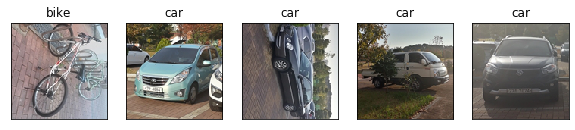

In [4]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
    image = image / 2 + 0.5 #unnormalize
    return image

#무작위로 이미지 선택
dataiter = iter(trainloader)
images, labels = dataiter.next()

#선택된 이미지 출력
fig = plt.figure(figsize = (10,5))
for i in np.arange(train_batch):
    # row 2 column 10
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title(classes[labels[i].item()])

In [5]:
#input=128, color=3(RGB)
#conv1 = 5*5 filter >>> -4px (filter-1)
#pool1 = 4*4 >>> /4px
#conv2 = 4*4 filter >>> -3px
#pool2 = 4*4 >>> /4px
#fc1 = ((128 - 4) / 4 - 3) / 4 = 7*7

class LeNet(nn.Module):
  
    def __init__(self):
        super().__init__()
        #colorchannel, feature, filter, stride 순서로 입력
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        #feature, feature2, filter, stride
        self.conv2 = nn.Conv2d(20, 50, 4, 1)
        #fc1^2*feature2, feature3
        self.fc1 = nn.Linear(7*7*50, 500)
        #과적합 방지용
        self.dropout1 = nn.Dropout(0.5)
        #feature3, class_num
        self.fc2 = nn.Linear(500, class_num)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #pool1
        x = F.max_pool2d(x, 4, 4)
        x = F.relu(self.conv2(x))
        #pool2
        x = F.max_pool2d(x, 4, 4)
        #flatten: -1, fc1^2*feature2
        x = x.view(-1, 7*7*50)
        #activation function
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [6]:
net = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(4):    #반복 횟수 설정

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        #Gradient 0으로
        optimizer.zero_grad()

        #순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #학습 진행상황 출력
        running_loss += loss.item()
        print('[epoch: %d, batch: %3d] loss: %.5f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

print('학습 완료')

[epoch: 1, batch:   1] loss: 0.00035
[epoch: 1, batch:   2] loss: 0.00061
[epoch: 1, batch:   3] loss: 0.00035
[epoch: 1, batch:   4] loss: 0.00050
[epoch: 1, batch:   5] loss: 0.00037
[epoch: 1, batch:   6] loss: 0.00034
[epoch: 1, batch:   7] loss: 0.00034
[epoch: 1, batch:   8] loss: 0.00035
[epoch: 2, batch:   1] loss: 0.00034
[epoch: 2, batch:   2] loss: 0.00034
[epoch: 2, batch:   3] loss: 0.00032
[epoch: 2, batch:   4] loss: 0.00036
[epoch: 2, batch:   5] loss: 0.00030
[epoch: 2, batch:   6] loss: 0.00031
[epoch: 2, batch:   7] loss: 0.00028
[epoch: 2, batch:   8] loss: 0.00029
[epoch: 3, batch:   1] loss: 0.00029
[epoch: 3, batch:   2] loss: 0.00020
[epoch: 3, batch:   3] loss: 0.00022
[epoch: 3, batch:   4] loss: 0.00024
[epoch: 3, batch:   5] loss: 0.00018
[epoch: 3, batch:   6] loss: 0.00022
[epoch: 3, batch:   7] loss: 0.00016
[epoch: 3, batch:   8] loss: 0.00006
[epoch: 4, batch:   1] loss: 0.00012
[epoch: 4, batch:   2] loss: 0.00006
[epoch: 4, batch:   3] loss: 0.00011
[

 bike 분류 정확도: 100 %
  car 분류 정확도: 100 %


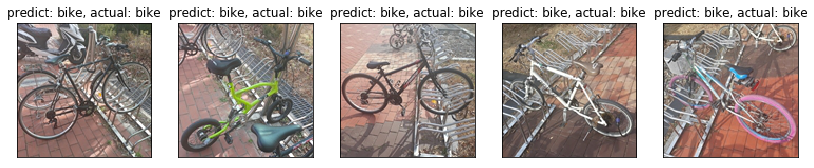

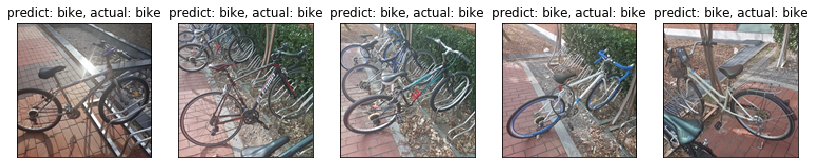

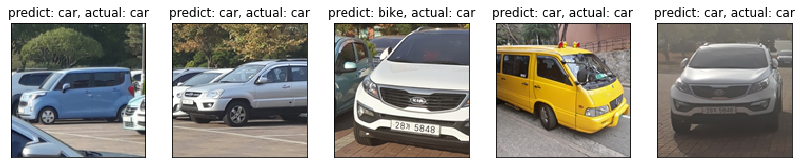

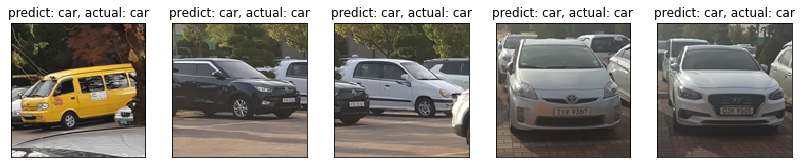

In [7]:
class_correct = list(0. for i in range(class_num))
class_total = list(0. for i in range(class_num))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        names = []
        for j in range(test_batch):
            names.append(classes[predicted[j]])

        #testset 이미지 출력
        fig = plt.figure(figsize = (14,5))
        for i in np.arange(test_batch):
            ax = fig.add_subplot(1, test_batch, i+1, xticks=[], yticks=[])
            plt.imshow(im_convert(images[i]))
            #title 설정. 예측값과 실제값 순
            title = ('predict: ' + names[i] + ', actual: ' + classes[labels[i].item()])
            ax.set_title(title)
        
        for i in range(2):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(class_num):
    print('%5s 분류 정확도: %3d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))